These are the equations that model the Brusselator. 

$$\frac{dx}{dt} = A - (B + 1)x + x^2 y$$
$$\frac{dy}{dt} = Bx - x^2 y$$

In [1]:
import numpy as np
from scipy.integrate import solve_ivp

# Equation Parameters
A = 1.0
B = 1.5

def vector_function(t, state, a, b):
    '''
    Returns a 2D vector containing the derivatives `[dx/dt, dy/dt]` of the current state.
    '''
    x, y = state
    dx_dt = a - (b + 1)*x + x**2 * y
    dy_dt = b*x - x**2 * y
    # Shape is defined by this return value.
    return [dx_dt, dy_dt]

T_START = 0
T_END = 50
TIME_SPAN = (T_START, T_END)
t_points = np.linspace(T_START, T_END, num=100)

def solve(a = A, b = B):
    '''
    Uses `solve_ivp()` function to solve equation. Returns the results as arrays of
    an object (e.g. time solutions are `solve().t`, x solutions are `solve().y[0]`,
    and y-solutions are `solve().y[1]`).
    '''
    x_0 = 1.2
    y_0 = 2.8
    initial_conditions = (x_0, y_0)
    return solve_ivp(
        vector_function,
        args=(a, b),
        t_span=TIME_SPAN,
        t_eval=t_points,
        y0=initial_conditions,
        method='BDF',
    )
    
solutions = solve()
# BDF had 244 function calls and RK45 had 188.
print(f"Number of Function Evaluations: {solutions.nfev}")
t_solutions = solutions.t
x_solutions = solutions.y[0]
y_solutions = solutions.y[1]

Number of Function Evaluations: 244


Now, it's time to graph the solutions for $x$ and $y$ with respect to $t$.

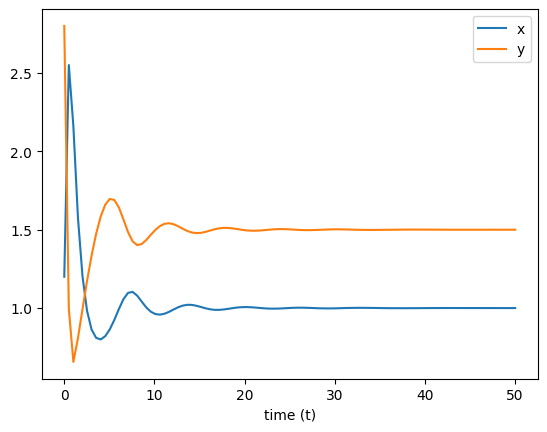

In [2]:
import matplotlib.pyplot as plt

def plot_xy_by_t(axes, t_pts, x_sol = None, y_sol = None, show_legend = True):
    axes.set_xlabel('time (t)')
    if x_sol is not None:
        axes.plot(t_pts, x_sol, label='x')
    if y_sol is not None:
        axes.plot(t_pts, y_sol, label='y')
    if show_legend:
        axes.legend()
    # ax.axhline(y=A, linestyle='--', color='r')
    # ax.axhline(y=B, linestyle='--', color='g')

fig, ax = plt.subplots()

plot_xy_by_t(
    ax,
    t_points,
    x_solutions,
    y_solutions
)

plt.show()

Now, I am plotting the positions of the $x$ and $y$ values over time $(x, y)$.

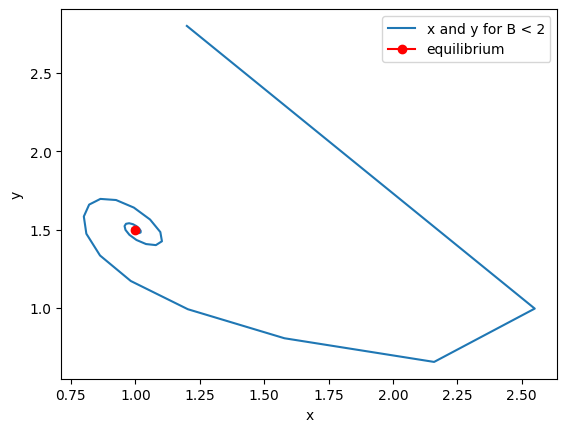

In [3]:
import matplotlib.pyplot as plt

# For some reason, if I run this cell individually, the graph is messed up.
fig, ax = plt.subplots()
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.plot(x_solutions, y_solutions, label='x and y for B < 2')
ax.plot(A, B, marker='o', color='red', label='equilibrium')
ax.legend()
plt.show()

Paramter sweep of $B$ over $[1.2, 3.5]$.

Behavior for B=1.2: equilibrium
Behavior for B=1.409: equilibrium
Behavior for B=1.618: equilibrium
Behavior for B=1.827: equilibrium
Behavior for B=2.036: oscilating
	Period: 12.714285714285714
	Amplitude: 1.4157938739287645
Behavior for B=2.245: oscilating
	Period: 12.571428571428571
	Amplitude: 1.7293509561357276
Behavior for B=2.455: oscilating
	Period: 12.857142857142858
	Amplitude: 2.0779809792855346
Behavior for B=2.664: oscilating
	Period: 13.142857142857142
	Amplitude: 2.292261288661704
Behavior for B=2.873: oscilating
	Period: 13.571428571428571
	Amplitude: 2.5132394528867184
Behavior for B=3.082: oscilating
	Period: 14.166666666666666
	Amplitude: 2.7107967626170364
Behavior for B=3.291: oscilating
	Period: 15.2
	Amplitude: 3.2215357002297105
Behavior for B=3.5: oscilating
	Period: 15.8
	Amplitude: 3.719785521967084


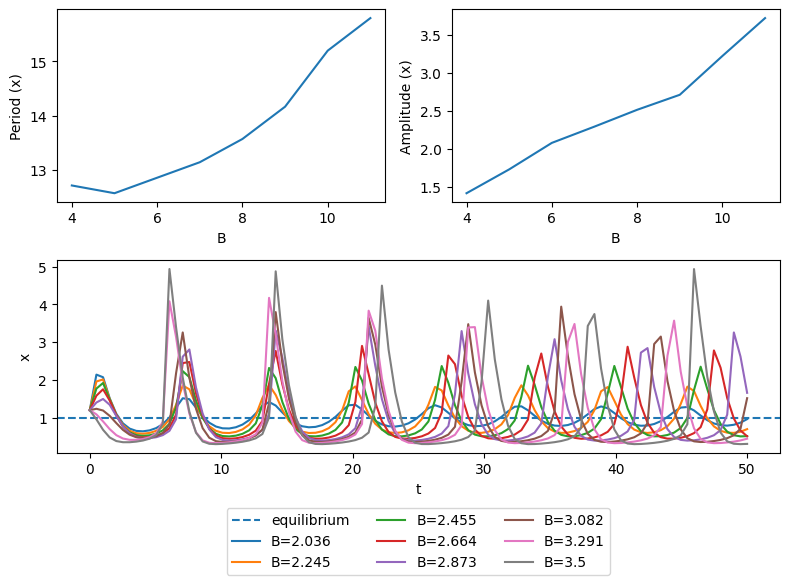

In [4]:
from typing import Literal
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

def classify_behavior(t_sol, x_sol) -> Literal['equilibrium', 'oscilating']:
    # This is the tolerance for how much the function can deviate from the mean in interval. 
    # If the function is within tolerance, then it is classifed as being at equilibrium. I
    # found this number by just testing smaller and smaller values.
    TOLERANCE = 0.05
    # This test is only concerned about the end behavior, so it only considers the last (100 - END_THRESHOLD)%.
    END_THRESHOLD = int(len(t_sol) * 0.8)
    # Extract the last (100 - END_THRESHOLD)% of x-values
    x_solutions = x_sol[END_THRESHOLD:]
    standard_deviation =  np.std(x_solutions)
    if standard_deviation <= TOLERANCE:
        return 'equilibrium'
    else:
        return 'oscilating'

def estimate_value(x_idx, x_values, y_values) -> int:
    '''
    Estimates the value of y at x by taking the average of neighboring values.
    Works well when x-values are close together.
    '''

    # Finds the minimum of the difference between each x-value and x.
    # 
    # I can find the values by getting the first index since each value in
    # x_values in unique.
    x_1 = np.argmin(np.abs(x_values - x_values[x_idx]))
    # The next x-value after the closest one.
    x_2 = min(x_1 + 1, len(x_values) - 1)
    y_1 = y_values[x_1]
    y_2 = y_values[x_2]
    return (y_1 + y_2) / 2
    

def calc_amplitude_and_period(x_values, y_values) -> tuple[float, float]:
    peaks, _ = find_peaks(y_values)
    # Calculates the average period.
    period = np.mean(np.abs(np.diff(peaks)))
    # Calculates the average amplitude at each peak.
    amplitudes = [estimate_value(peak, x_values, y_values) for peak in peaks]
    avg_amplitude = np.average(amplitudes)
    return (period, avg_amplitude)
    

b_start = 1.2
b_end = 3.5
b_points = np.linspace(b_start, b_end, num=12)

periods = []
amplitudes = []
oscilating_indexes = []

# fig, (period_ax, amplitude_ax) = plt.subplots(1, 2)
fig, axs = plt.subplot_mosaic(
    [
        ["P", "A"], # Top row is split into period and amplitude graphs
        ["S", "S"]  # Bottom row is for solutions graph
    ],
    figsize=(8, 6) # 8x6 in, standard 4:3 aspect ration.
)

period_ax = axs["P"]
amplitude_ax = axs["A"]
solutions_ax = axs["S"]

solutions_ax.set_xlabel("t")
solutions_ax.set_ylabel("x")
solutions_ax.axhline(y=1, linestyle="--", label = "equilibrium")

for idx, point in enumerate(b_points):
    solutions = solve(b=point)
    t_solutions = solutions.t
    x_solutions = solutions.y[0]
    behavior = classify_behavior(t_solutions, x_solutions)
    print(f'Behavior for B={point.round(3)}: {behavior}')
    if behavior == 'oscilating':
        (period, amplitude) = calc_amplitude_and_period(
            x_values=t_solutions,
            y_values=x_solutions
        )
        print(f"\tPeriod: {period}")
        print(f"\tAmplitude: {amplitude}")
        # Adding oscilating values to lists.
        periods.append(period)
        amplitudes.append(amplitude)
        oscilating_indexes.append(idx)
        # Plotting solution
        solutions_ax.plot(t_solutions, x_solutions, label = f"B={point.round(3)}")

oscilating_b_points = [b_points[i] for i in oscilating_indexes]

solutions_ax.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.25),
    ncol=3
)

period_ax.plot(oscilating_indexes, periods)
period_ax.set_xlabel("B")
period_ax.set_ylabel("Period (x)")

amplitude_ax.plot(oscilating_indexes, amplitudes)
amplitude_ax.set_xlabel("B")
amplitude_ax.set_ylabel("Amplitude (x)")

fig.tight_layout()

plt.show()